In [206]:
from qiskit import QuantumRegister, ClassicalRegister, AncillaRegister, QuantumCircuit
from qiskit.circuit.classical import expr

#Sets up the registers and classical register dictionary
def initialize_QEC_Circuit():
    logical_qreg = QuantumRegister(7, 'q')
    ancilla_qreg = AncillaRegister(3, 'a')
    setter_qreg = QuantumRegister(2, "setters")
    prev_syn = ClassicalRegister(6, "ps")
    curr_syn = ClassicalRegister(3, "s")
    syn_diff = ClassicalRegister(6, "sd")
    flag_diff = ClassicalRegister(6, "fd")
    pauli_frame = ClassicalRegister(2, "pf")
    final_meas = ClassicalRegister(7, "fm")
    output = ClassicalRegister(1, 'o')
    creg_dict = {"prev_syn": 0, "curr_syn": 1, "syn_diff": 2, "flag_diff": 3, "pauli_frame": 4, "final_meas": 5, "output": 6}
    circuit = QuantumCircuit(logical_qreg, ancilla_qreg, setter_qreg, prev_syn, curr_syn, syn_diff, flag_diff, pauli_frame, final_meas, output)
    circuit.x(setter_qreg[1])
    return circuit, creg_dict

#Adds the encoding circuit to create the logical basis states
def create_encodingcircuit(circuit):
    circuit.h(0)
    circuit.h(4)
    circuit.h(6)
    circuit.cx(0, 1)
    circuit.cx(4, 5)
    circuit.cx(6, 3)
    circuit.cx(6, 5)
    circuit.cx(4, 2)
    circuit.cx(0, 3)
    circuit.cx(4, 1)
    circuit.cx(3, 2)
    circuit.barrier()

#Adds a group of stabilizers to the circuit
def add_stabilizers(circuit, stabilizers, sgroup):
    for i in range(len(stabilizers)):
        stabilizer = sgroup[stabilizers[i]-1]
        if stabilizer[0] == 'X':
            circuit.h(circuit.ancillas[i])
            for index in stabilizer[1]:
                circuit.cx(circuit.ancillas[i], circuit.qregs[0][index])
            circuit.h(circuit.ancillas[i])
            
        if stabilizer[0] == 'Z':
            for index in stabilizer[1]:
                circuit.cx(circuit.qregs[0][index], circuit.ancillas[i])

        circuit.barrier()
        
def reset_ancillas(circuit):
    for n in range(circuit.num_ancillas):
        circuit.reset(circuit.ancillas[n])

def set_cbit(circuit, creg, cregs, ind, value):
    if value == 0:
        circuit.measure(circuit.qregs[2][0], circuit.cregs[cregs[creg]][ind])
    else:
        circuit.measure(circuit.qregs[2][1], circuit.cregs[cregs[creg]][ind])

def flip_cbit(circuit, creg, cregs, ind):
    with circuit.if_test(expr.lift(circuit.cregs[cregs[creg]][ind])) as _else:
        set_cbit(circuit, creg, cregs, ind, 0)
    with _else:
        set_cbit(circuit, creg, cregs, ind, 1)

#Performs AND and NOT statements on multiple classical bits, e.g. (~c[0] & ~c[1] & c[2])
def cbit_and(cbits, values):
    result = expr.bit_not(cbits[0]) if values[0] == 0 else expr.lift(cbits[0])
    for n in range(len(cbits)-1):
        result = expr.bit_and(result, expr.bit_not(cbits[n+1])) if values[n+1] == 0 else expr.bit_and(result, cbits[n+1])
    return result

#XOR multiple classical bits
def cbit_xor(creg, cbits):
    result = expr.lift(creg[cbits[0]])
    for n in range(len(cbits)-1):
        result = expr.bit_xor(result, creg[cbits[n+1]])
    return result


def measure_syndrome_diff(circuit, stabs, sgroup, cregs, flagged):
    creg = "flag_diff" if flagged else "syn_diff"
    curr_syn = circuit.cregs[cregs["curr_syn"]]
    prev_syn = circuit.cregs[cregs["prev_syn"]]
    
    #Applies and measures stabilizers for the desired syndrome
    add_stabilizers(circuit, stabs, sgroup)
    for n in range(circuit.num_ancillas):
        circuit.measure(circuit.ancillas[n], curr_syn[n])

    #Determines the syndrome difference
    for n in range(len(stabs)):
        with circuit.if_test(expr.bit_xor(curr_syn[n], prev_syn[stabs[n]-1])) as _else:
            set_cbit(circuit, creg, cregs, stabs[n]-1, 1)
        with _else:
            set_cbit(circuit, creg, cregs, stabs[n]-1, 0)

    circuit.barrier()
    reset_ancillas(circuit)
    circuit.barrier()

def apply_decoding(circuit, cregs, stabs, sgroup, with_flagged):
    syn_diff = circuit.cregs[cregs["syn_diff"]][stabs[0]-1:stabs[len(stabs)-1]]
    #Determines index of pauli frame to be modified
    pf_ind = 0 if sgroup[stabs[0]-1][0] == 'X' else 1

    #Decoding sequence with flagged syndrome
    if with_flagged:
        flag_diff = circuit.cregs[cregs["flag_diff"]][stabs[0]-1:stabs[len(stabs)-1]]
        with circuit.if_test(expr.bit_and(cbit_and(flag_diff, [1, 0, 0]), cbit_and(syn_diff, [0, 1, 0]))):
            flip_cbit(circuit, "pauli_frame", cregs, pf_ind)
        with circuit.if_test(expr.bit_and(cbit_and(flag_diff, [1, 0, 0]), cbit_and(syn_diff, [0, 0, 1]))):
            flip_cbit(circuit, "pauli_frame", cregs, pf_ind)
        with circuit.if_test(expr.bit_and(cbit_and(flag_diff, [0, 1, 1]), cbit_and(syn_diff, [0, 0, 1]))):
            flip_cbit(circuit, "pauli_frame", cregs, pf_ind)
    
    #Unflagged decoding sequence
    else:
        with circuit.if_test(cbit_and(syn_diff, [0, 1, 0])):
            flip_cbit(circuit, "pauli_frame", cregs, pf_ind)
        with circuit.if_test(cbit_and(syn_diff, [0, 1, 1])):
            flip_cbit(circuit, "pauli_frame", cregs, pf_ind)
        with circuit.if_test(cbit_and(syn_diff, [0, 0, 1])):
            flip_cbit(circuit, "pauli_frame", cregs, pf_ind)
            


def apply_QEC_cycle(circuit, sgroup, sx, sz, fs1, fs2, cregs):

    #Measures first flagged syndrome
    measure_syndrome_diff(circuit, fs1, sgroup, cregs, flagged=True)

    #If no change in syndrome, measures second flag circuit
    with circuit.if_test(expr.equal(circuit.cregs[cregs["flag_diff"]], 0)):
        measure_syndrome_diff(circuit, fs2, sgroup, cregs, flagged=True)

    #If change in syndrome, unflagged syndrome is extracted and decoding is applied
    with circuit.if_test(expr.not_equal(circuit.cregs[cregs["flag_diff"]], 0)):
        measure_syndrome_diff(circuit, sx, sgroup, cregs, flagged=False)
        measure_syndrome_diff(circuit, sz, sgroup, cregs, flagged=False)

        apply_decoding(circuit, cregs, sx, sgroup, with_flagged=False)
        apply_decoding(circuit, cregs, sz, sgroup, with_flagged=False)
        apply_decoding(circuit, cregs, sx, sgroup, with_flagged=True)
        apply_decoding(circuit, cregs, sz, sgroup, with_flagged=True)

        #Updates previous syndrome
        syn_diff = circuit.cregs[cregs["syn_diff"]]
        for n in range(len(syn_diff)):
            with circuit.if_test(expr.lift(syn_diff[n])):
                flip_cbit(circuit, "prev_syn", cregs, n)

def measure_output(circuit, cregs, sz, sgroup):
    #Measurement of state
    final_meas = circuit.cregs[cregs["final_meas"]]
    for n in range(len(final_meas)):
        circuit.measure(circuit.qregs[0][n], final_meas[n])

    with circuit.if_test(cbit_xor(final_meas, [4,5,6])):
        set_cbit(circuit, "output", cregs, 0, 1)

    #Final syndrome
    for n in range(len(sz)):
        with circuit.if_test(cbit_xor(final_meas, sgroup[sz[n]-1][1])):
            set_cbit(circuit, "curr_syn", cregs, n, 1)

    #Final syndrome diff
    curr_syn = circuit.cregs[cregs["curr_syn"]]
    prev_syn = circuit.cregs[cregs["prev_syn"]]
    for n in range(len(sz)):
        with circuit.if_test(expr.bit_xor(curr_syn[n], prev_syn[sz[n]-1])) as _else:
            set_cbit(circuit, "syn_diff", cregs, sz[n]-1, 1)
        with _else:
            set_cbit(circuit, "syn_diff", cregs, sz[n]-1, 0)

    #Final correction
    apply_decoding(circuit, cregs, sz, sgroup, with_flagged=False)
    pauli_frame = circuit.cregs[cregs["pauli_frame"]]
    with circuit.if_test(expr.lift(pauli_frame[1])):
        flip_cbit(circuit, "output", cregs, 0)

    



In [207]:
#Sets up the QEC circuit
QEC_circuit, c_registers = initialize_QEC_Circuit()

#Define stabilizers
s1 = ['X', [0,1,2,3]]
s2 = ['X', [1,2,4,5]]
s3 = ['X', [2,3,5,6]]
s4 = ['Z', [0,1,2,3]]
s5 = ['Z', [1,2,4,5]]
s6 = ['Z', [2,3,5,6]]
stabilizer_group = [s1, s2, s3, s4, s5, s6]
x_stabilizers = [1, 2, 3]
z_stabilizers = [4, 5, 6]
first_flagged_stabilizers = [1, 5, 6]
second_flagged_stabilizers = [2, 3, 4]

#Build encoding circuit
create_encodingcircuit(QEC_circuit)

#Error occurs
QEC_circuit.x(6)
QEC_circuit.barrier()

#Applies desired amount of QEC cycles
cycles = 1
for i in range(cycles):
    apply_QEC_cycle(QEC_circuit, stabilizer_group, x_stabilizers, z_stabilizers, first_flagged_stabilizers, second_flagged_stabilizers, c_registers)

#Applies the output measurement circuit
measure_output(QEC_circuit, c_registers, z_stabilizers, stabilizer_group)
    

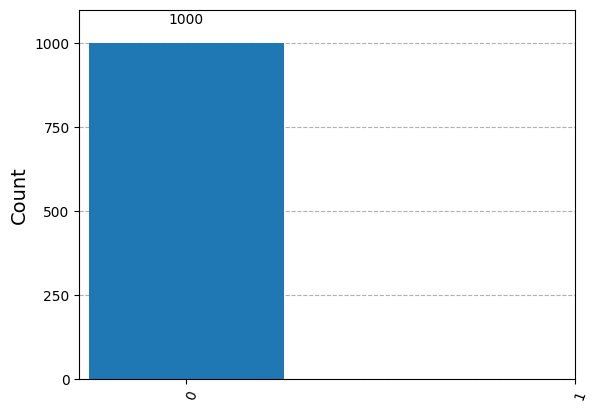

In [210]:
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram

#Runs the circuit on the simulator and tracks how many times the final state is measured as a 0 or 1
shots = 1000
simulator = AerSimulator()
qc = transpile(QEC_circuit, backend=simulator)
result = simulator.run(qc, shots=shots, memory=True).result()
output = result.get_memory(QEC_circuit)
zeros = 0
ones = 0
for n in range(shots):
    if int(output[n][0]) == 0:
        zeros += 1
    if int(output[n][0]) == 1:
        ones += 1

counts = {'0': zeros, '1': ones}
plot_histogram(counts)        

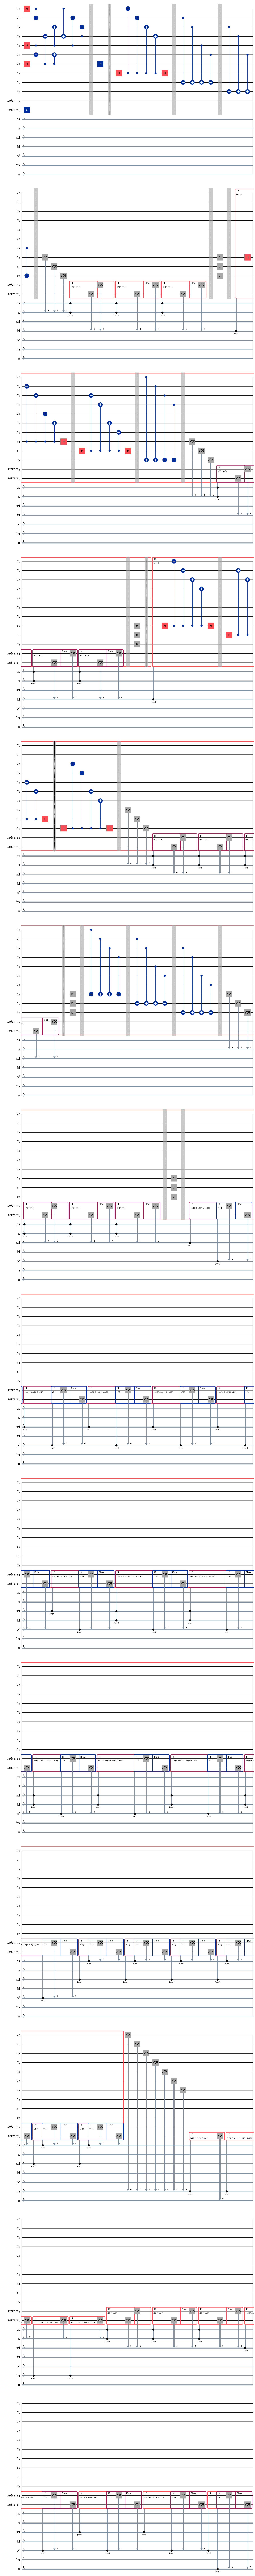

In [211]:
#Draws final circuit with classical controls
QEC_circuit.draw('mpl', style='iqp', cregbundle=True)